In [126]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.inspection import permutation_importance
import IPython

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# set up to view all the info of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Input Data**
* Data stored in a csv file are stored in a dataframe

In [127]:
cars_original = pd.read_csv(r'C:\Users\margh\OneDrive\Documenti\GIT\Marketing_Analytics\car_data.csv')
cars_original.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### **Exploratory Data Analysis**
* The analysis report presents that the DataFrame has 11914 rows and each row represents one car. The DataFrame has 16 features, 8 of which are catergorical. Engine Fuel Type, Engine HP, Engine Cylinders, Number of Doors, Market Category present missing values.

In [128]:
#@ Exploratory Data Analysis:
cars_original.info()                  # Inspecting the DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

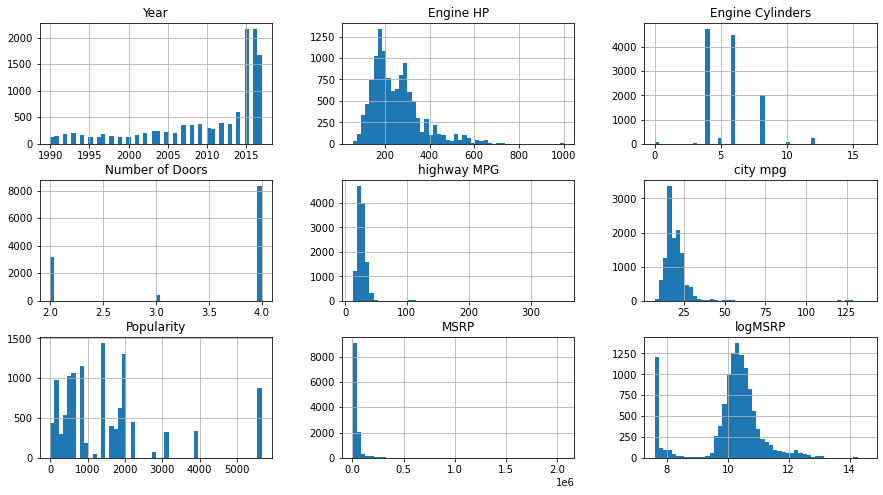

In [129]:
#@ Inspecting the Data using Histograms:
%matplotlib inline
import matplotlib.pyplot as plt  
cars = cars_original.copy()
cars['logMSRP']= np.log(cars.MSRP)
cars.hist(bins=50, figsize=(15, 8)) 
plt.show()

### **Year**
* There is a major change at year 2000 in prices.
I test also separate analysis for the two sectors

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 200000.0)

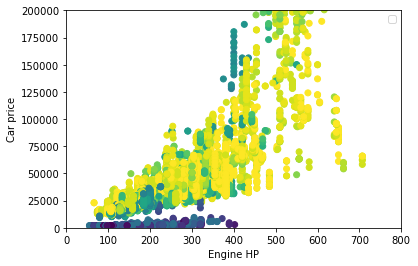

In [130]:
fig, ax = plt.subplots(1,1)

ax.scatter(cars['Engine HP'], cars.MSRP, c=cars.Year)

ax.legend()
ax.set_xlabel('Engine HP')
ax.set_ylabel('Car price')
ax.set_xlim([0,800])
ax.set_ylim([0, 200000])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 100000.0)

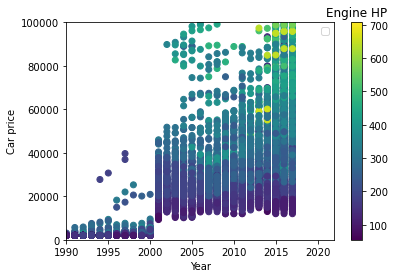

In [274]:
fig, axes = plt.subplots(1,1)

pricemax = 100000
ax = axes
sc = ax.scatter(cars[cars.MSRP<pricemax].Year, cars[cars.MSRP<pricemax].MSRP, c=cars[cars.MSRP<pricemax]['Engine HP'])

ax.set_xlabel('Year')
ax.legend()
cbar=fig.colorbar(sc)
cbar.ax.set_title('Engine HP')
ax.set_ylabel('Car price')
ax.set_xlim([1990, 2022])
ax.set_ylim([0, pricemax])


### **Clean the database**
* The database presents missing values, probably wrong values and cathegorical variables. The first two categories will be fixed while the third will be transformed in numberical by one hot encoding

### **Number of Doors**
* There is clearly a different definition for the number of doors, so I changed 3 to 2 for coherence

In [134]:

cars[cars['Number of Doors'] == 3]['Number of Doors']=2


### **Outliers**
* I checked the outliers. The value of highway MPG>300 is a mistype so I removed it ( I could have fixed but I did not see the point)


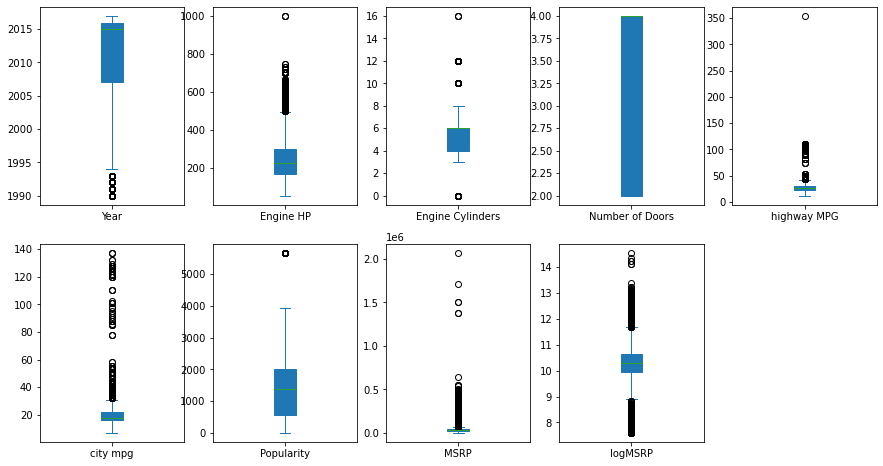

In [135]:
# See if there is any outliers

# select columns to plot


# subplots
cars.plot(subplots=True, layout=(2,5), kind='box', figsize=(15,8), patch_artist=True)

plt.savefig('boxplots.png', bbox_inches='tight')

cars = cars[cars['highway MPG']<200]

### **Fill Nan**
* Engine Fuel Type: only 3 are missing, so I fill with the average value of the same make and model, which is constant
* Missing vlues for electric cars are averaged over electric cars only
* Flex fuel with gas is the average of the same MAKE/MODEL/YEAR

In [136]:

fill_mode = lambda g:g.fillna(g.value_counts().idxmax()[0])
cars[['Engine Fuel Type']] = cars[['Engine Fuel Type']].groupby([cars['Make'],cars['Model']]).apply(fill_mode)

fill_mean = lambda g: g.fillna(round(g.mean()))
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Make'],cars['Model'],cars['Year'],cars['Engine Fuel Type']]).apply(fill_mean)
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Make'],cars['Model'],cars['Engine Fuel Type']]).apply(fill_mean)
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Engine Fuel Type']]).apply(fill_mean)
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Make'],cars['Model'],cars['Year']]).apply(fill_mean)
cars[['Number of Doors' ]] = cars[['Number of Doors']].groupby([cars['Make'],cars['Model'],cars['Year']]).apply(fill_mean)
cars[['Number of Doors' ]] = cars[['Number of Doors']].groupby([cars['Make'],cars['Model']]).apply(fill_mean)

cars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11913 entries, 0 to 11913
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11913 non-null  object 
 1   Model              11913 non-null  object 
 2   Year               11913 non-null  int64  
 3   Engine Fuel Type   11913 non-null  object 
 4   Engine HP          11913 non-null  float64
 5   Engine Cylinders   11913 non-null  float64
 6   Transmission Type  11913 non-null  object 
 7   Driven_Wheels      11913 non-null  object 
 8   Number of Doors    11913 non-null  float64
 9   Market Category    8171 non-null   object 
 10  Vehicle Size       11913 non-null  object 
 11  Vehicle Style      11913 non-null  object 
 12  highway MPG        11913 non-null  int64  
 13  city mpg           11913 non-null  int64  
 14  Popularity         11913 non-null  int64  
 15  MSRP               11913 non-null  int64  
 16  logMSRP            119

### **Extra Variables**
* I will add the variable log of the price, that seems promsing as target variable because it will balance the influence of low price cars in the loss function

In [137]:
makes =set(cars['Make'])
models = set(cars['Model'])


y = cars[['MSRP']]
ys = cars[['MSRP','logMSRP']]
X = cars.drop(columns=['MSRP','logMSRP'])


### **Split**
* Random split between test / val / train. We split randomly each make as we want in the training / val/test elements of each make

In [138]:
for i,make in enumerate(makes):
    X_tmp = X[cars.Make == make]
    y_tmp = ys[cars.Make == make]

    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(X_tmp,y_tmp, test_size=0.2, random_state=1)
    X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train_tmp, y_train_tmp, test_size=0.25, random_state=1)
    if i==0:
        X_train = X_train_tmp
        X_test = X_test_tmp
        X_val = X_val_tmp
    else:
        X_train = pd.concat([X_train, X_train_tmp], axis=0)
        X_test = pd.concat([X_test, X_test_tmp], axis=0)
        X_val = pd.concat([X_val, X_val_tmp], axis=0)

    if i==0:
        ys_train = y_train_tmp
        ys_test = y_test_tmp
        ys_val = y_val_tmp
    else:
        ys_train = pd.concat([ys_train, y_train_tmp], axis=0)
        ys_test = pd.concat([ys_test, y_test_tmp], axis=0)
        ys_val = pd.concat([ys_val, y_val_tmp], axis=0)

### **Support functions**
* prepare_data: it creates data structure with one hot encoding. If the analysis is performed make by make, The columns of one hot encoding are the merge of the columns needed in test, train and val set for that make.
* plot_result_1: comparison on expected and predicted results 

**Market category**
* This column includes a list of elements
* it is transformed in several columns, one for each element

In [139]:
def create_one_hot(X,make=''):
    if make!='':
        X=X.drop(columns=['Make'])
    mc = X['Market Category'].str.get_dummies(',')
    c_0 =X.drop('Market Category', axis = 1)
    X = pd.concat([c_0, mc], axis=1)
    X=pd.get_dummies(X)
    return X


def prepare_data(make,X_train,X_val,X_test,y_train,y_val,y_test):
    if make == '':
        
        X_train_tmp =  create_one_hot(X_train)
        X_val_tmp =   create_one_hot(X_val)
        X_test_tmp =   create_one_hot(X_test)
        y_train_tmp = y_train
        y_val_tmp = y_val
        y_test_tmp = y_test

    else:

        X_train_tmp =  create_one_hot(X_train[X_train.Make == make],make)
        X_val_tmp =   create_one_hot(X_val[X_val.Make == make],make)
        X_test_tmp =   create_one_hot(X_test[X_test.Make == make],make)
        y_train_tmp = y_train[X_train.Make == make]
        y_val_tmp = y_val[X_val.Make == make]
        y_test_tmp = y_test[X_test.Make == make]

    train_col=X_train_tmp.columns
    val_col=X_val_tmp.columns
    test_col=X_test_tmp.columns

    cols = list(set(np.concatenate((train_col,test_col,val_col))))
    
    for col in cols:
        if (not (col in X_train_tmp.columns)):
            X_train_tmp[col] = 0
        if (not (col in X_val_tmp.columns)):
            X_val_tmp[col] = 0
        if (not (col in X_test_tmp.columns)):
            X_test_tmp[col] = 0


    X_train_tmp =  X_train_tmp[cols]
    X_val_tmp =  X_val_tmp[cols]
    X_test_tmp =  X_test_tmp[cols]
    return [ X_train_tmp,X_val_tmp,X_test_tmp,np.ravel (y_train_tmp),np.ravel (y_val_tmp),np.ravel (y_test_tmp)]

### **Metrics**
* This is my chioice. I aim to obtain the best mean_absolute_percentage_error, while the loss function used in the random forest is the RMSE target value (I test the price as the log of the price as target variables)

In [140]:
def plot_result_1(y_val, y_val_pred,ylog = False,title= 'validation'):
    if ylog:
        y_val = np.exp(y_val)
        y_val_pred = np.exp(y_val_pred)
    error = metrics.mean_absolute_percentage_error(y_val, y_val_pred, )
    print(' Mean Absolute percentage Error:', error )


    fig, axes = plt.subplots(1,3)
    fig.set_size_inches(14, 3)
    fig.tight_layout()
    fig.subplots_adjust(left=0.1,  bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

    ax= axes[0]
    ax.scatter(np.ravel (y_val), np.ravel (y_val_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_xlabel('Real value')
    ax.set_ylabel('Predicted value')


    ax= axes[1]
    ax.scatter(np.ravel (y_val), np.ravel (y_val_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_title(title+' - recorded vs predicted ')
    ax.set_xlabel('Real value')
    ax.set_ylabel('Predicted value')
    ax.set_xlim([0, 500000])
    ax.set_ylim([0, 500000])
    


    ax= axes[2]
    ax.scatter(np.ravel (y_val), np.ravel (y_val_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_xlabel('Real value')
    ax.set_ylabel('Predicted value')
    ax.set_xlim([0, 50000])
    ax.set_ylim([0, 50000])
    plt.show() 
    return error

In [ ]:
def plot_result_2(y_val, y_val_pred,ci,ylog = False,title= 'validation'):
    if ylog:
        y_val = np.exp(y_val)
        y_val_pred = np.exp(y_val_pred)
        ci = np.exp(ci)


    error = metrics.mean_absolute_percentage_error(y_val, y_val_pred, )
    print(' Mean Absolute percentage Error:', error )


    ci = abs(ci-y_val_pred)


    # Plot error bars for predicted MPG using unbiased variance
    fig, axes = plt.subplots(1,3)
    fig.set_size_inches(14, 3)
    fig.tight_layout()
    fig.subplots_adjust(left=0.1,  bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

    ax= axes[0]
    ax.set_xlabel('Real value')
    ax.set_ylabel('Predicted value')   
    ax.errorbar(np.ravel (y_val), np.ravel (y_val_pred), yerr=ci, fmt='o', c='gold',mfc='red',)    
    ax.scatter(np.ravel (y_val), np.ravel (y_val_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')


    ax= axes[1]
    ax.set_xlabel('Real value')
    ax.set_ylabel('Predicted value')   
    ax.errorbar(np.ravel (y_val), np.ravel (y_val_pred), yerr=ci, fmt='o', c='gold',mfc='red')    
    ax.scatter(np.ravel (y_val), np.ravel (y_val_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')

    ax.set_title(title+' - recorded vs predicted ')
    ax.set_xlim([0, 500000])
    ax.set_ylim([0, 500000])
    


    ax= axes[2]
    ax.set_xlabel('Real value')
    ax.set_ylabel('Predicted value')   
    ax.errorbar(np.ravel (y_val), np.ravel (y_val_pred), yerr=ci, fmt='o', c='gold',mfc='red'
        )    
    ax.scatter(np.ravel (y_val), np.ravel (y_val_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_xlim([0, 50000])
    ax.set_ylim([0, 50000])
    plt.show() 
    return error

### **Tuning**
* Several hyperparameter options and several algorithms are tested
* Most algorithms perform in a similar way on the validation test. I then opted for the simpler model with the same quality
* Log analysis slightly outperforms the non log one, no major differences
* whole analysis slightly outperforms the analysis make by make and period, however it is much more efficient

**Target = log of price, all makes**
* Several Random Forest and MLP algorithms are tested

In [141]:
ylog = True
if ylog:
    y_train = ys_train[['logMSRP']]
    y_val = ys_val[['logMSRP']]
    y_test = ys_test[['logMSRP']]
else:
    y_train = ys_train[['MSRP']]
    y_val = ys_val[['MSRP']]
    y_test = ys_test[['MSRP']]

In [142]:
rg_list = []
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=10, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=20, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=50, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=100, n_jobs=-1))

names = ['RF 10','RF 20','RF 50','RF 100']


for j ,rg in enumerate (rg_list):
    
    [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data( make='',X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train,y_val=y_val,y_test=y_test)
    rg.fit(X_train_tmp, y_train_tmp)
    y_val_pred=rg.predict(X_val_tmp)
    y_train_pred=rg.predict(X_train_tmp)
    y_test_pred=rg.predict(X_test_tmp)

            
    error =plot_result_1(y_val, y_val_pred,title = names[j]+ ' - Validation - log test',ylog = ylog)
    error =plot_result_1(y_train, y_train_pred,title = names[j]+ ' - Training - log test',ylog = ylog)

KeyboardInterrupt: 

**Target = log of price, subset of features**
* according to the feature importance, only the first 3 features
* all features except make and model which strongly increase the computational cost

 Mean Absolute percentage Error: 0.09524230867292378


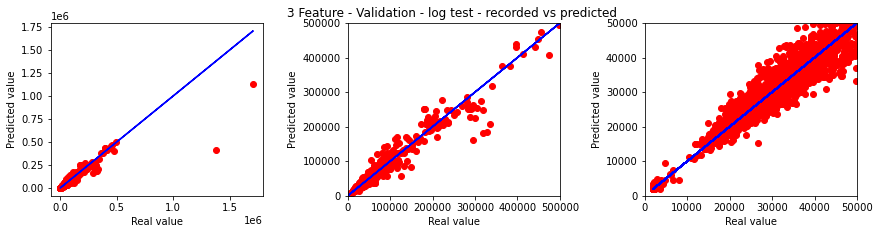

 Mean Absolute percentage Error: 0.06975351287001727


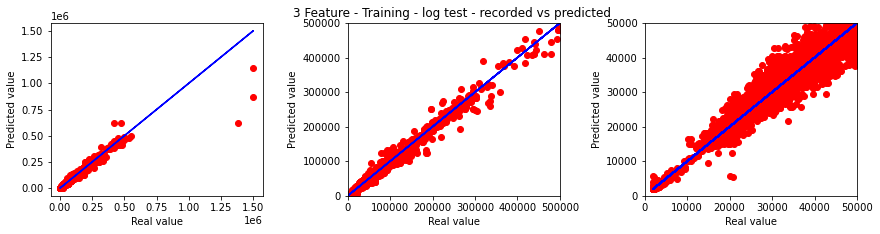

In [ ]:
rg= RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=20, n_jobs=-1)

       # X=X.drop(columns=['Make'])
[ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data( 
    make='',X_train=X_train[['Year','Engine HP', 'Market Category']],X_val=X_val[['Year','Engine HP', 'Market Category']],
    X_test=X_test[['Year','Engine HP', 'Market Category']],y_train=y_train,y_val=y_val,y_test=y_test)
rg.fit(X_train_tmp, y_train_tmp)
y_val_pred=rg.predict(X_val_tmp)
y_train_pred=rg.predict(X_train_tmp)
y_test_pred=rg.predict(X_test_tmp)

        
error =plot_result_1(y_val, y_val_pred,title =  '3 Feature - Validation - log test',ylog = ylog)
error =plot_result_1(y_train, y_train_pred,title = '3 Feature - Training - log test',ylog = ylog)

 Mean Absolute percentage Error: 0.07440648679278734


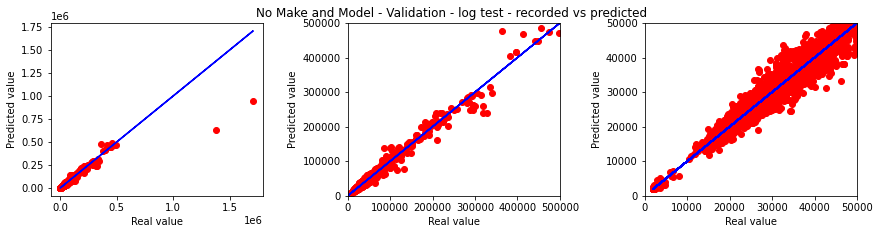

 Mean Absolute percentage Error: 0.043094682611222145


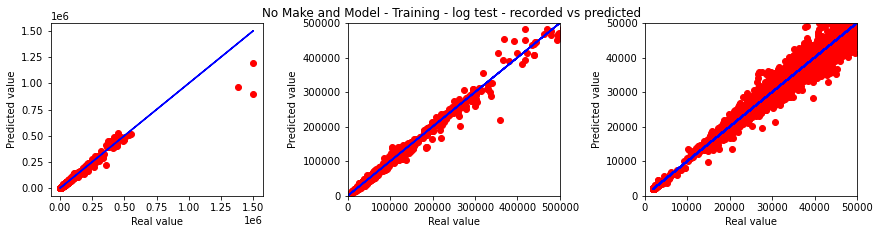

In [ ]:
rg= RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=20, n_jobs=-1)

[ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data( 
    make='',X_train=X_train.drop(columns=['Make', 'Model']),X_val=X_val.drop(columns=['Make', 'Model']),
    X_test=X_test.drop(columns=['Make', 'Model']),y_train=y_train,y_val=y_val,y_test=y_test)
rg.fit(X_train_tmp, y_train_tmp)
y_val_pred=rg.predict(X_val_tmp)
y_train_pred=rg.predict(X_train_tmp)
y_test_pred=rg.predict(X_test_tmp)

        
error =plot_result_1(y_val, y_val_pred,title = 'No Make and Model - Validation - log test',ylog = ylog)
error =plot_result_1(y_train, y_train_pred,title = 'No Make and Model - Training - log test',ylog = ylog)

**Target = price, all makes**
* Several Random Forest and MLP algorithms are tested

In [ ]:
ylog = False
if ylog:
    y_train = ys_train[['logMSRP']]
    y_val = ys_val[['logMSRP']]
    y_test = ys_test[['logMSRP']]
else:
    y_train = ys_train[['MSRP']]   
    y_val = ys_val[['MSRP']]
    y_test = ys_test[['MSRP']]

 Mean Absolute percentage Error: 0.10028142052685797


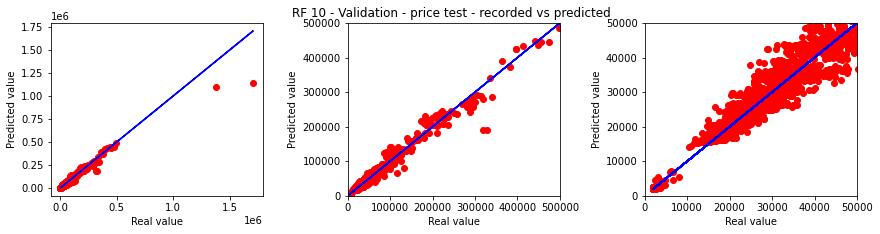

 Mean Absolute percentage Error: 0.09193831959603244


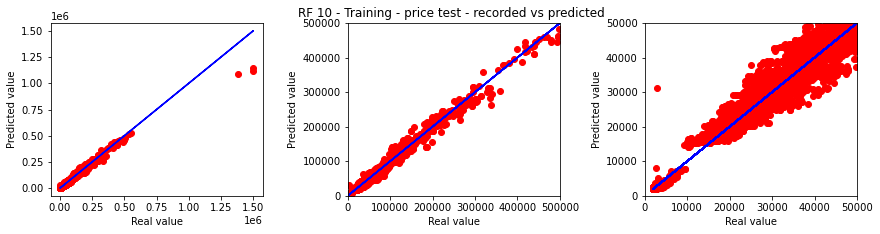

 Mean Absolute percentage Error: 0.07183104627080072


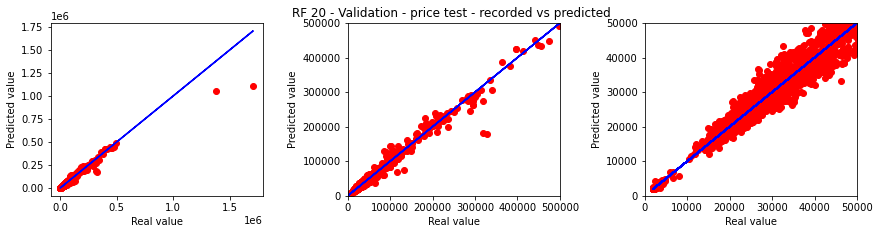

 Mean Absolute percentage Error: 0.046643132503229524


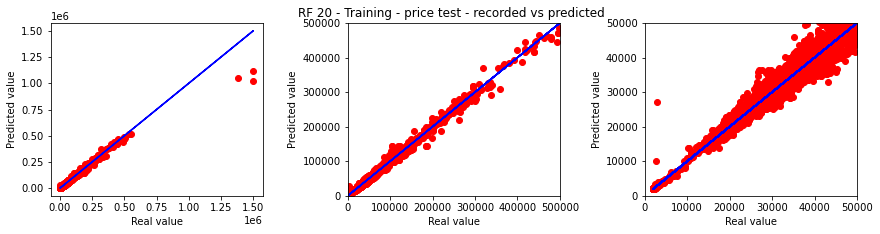

 Mean Absolute percentage Error: 0.07231272773308177


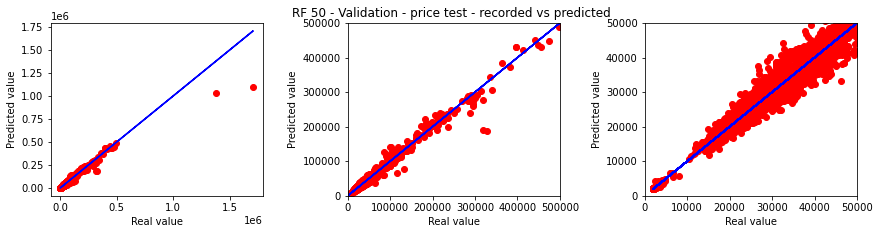

 Mean Absolute percentage Error: 0.04248493430633433


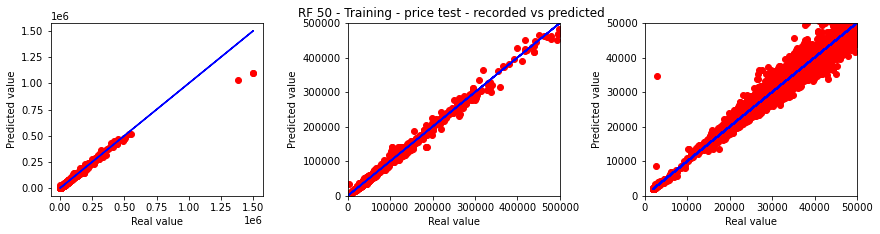

 Mean Absolute percentage Error: 0.0725632142230031


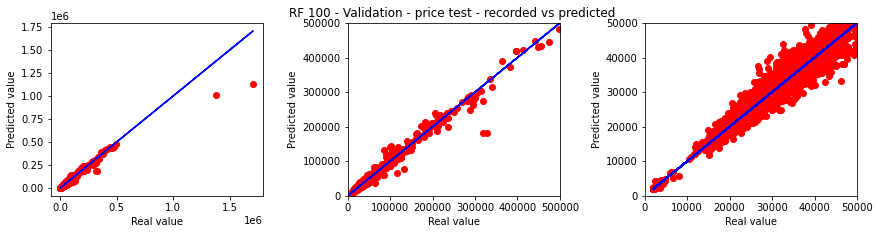

 Mean Absolute percentage Error: 0.04224206733828625


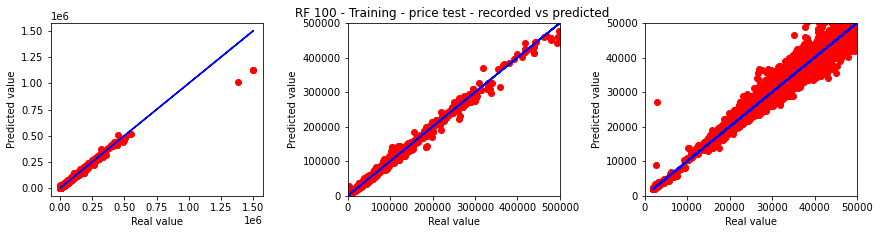

In [ ]:
rg_list = []
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=10, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=20, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=50, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=100, n_jobs=-1))

names = ['RF 10','RF 20','RF 50','RF 100']


for j ,rg in enumerate (rg_list):
    
    [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data( make='',X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train,y_val=y_val,y_test=y_test)
    rg.fit(X_train_tmp, y_train_tmp)
    y_val_pred=rg.predict(X_val_tmp)
    y_train_pred=rg.predict(X_train_tmp)
    y_test_pred=rg.predict(X_test_tmp)

            
    error =plot_result_1(y_val, y_val_pred,title = names[j]+ ' - Validation - price test',ylog = ylog)
    error =plot_result_1(y_train, y_train_pred,title = names[j]+ ' - Training - price test',ylog = ylog)

### **Feature importance**
* Several hyperparameter options and several algorithms are tested
* Most algorithms perform in a similar way on the validation test. I then opted for the simpler model with the same quality

In [219]:
ylog = True
if ylog:
    y_train = ys_train[['logMSRP']]
    y_val = ys_val[['logMSRP']]
    y_test = ys_test[['logMSRP']]
else:
    y_train = ys_train[['MSRP']]
    y_val = ys_val[['MSRP']]
    y_test = ys_test[['MSRP']]

In [220]:

niter=10
rg= RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=20, n_jobs=-1)

[ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data( make='',X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train,y_val=y_val,y_test=y_test)
rg.fit(X_train_tmp, y_train_tmp)
ind=[i for i in X_val.columns].append('Best Result')
perm = pd.DataFrame(columns=['AVG_Importance'], index=ind)
y_val_pred=rg.predict(X_val_tmp)
print('y_val_tmp',y_val_tmp)
print('y_val_pred',y_val_pred)   
if ylog:
    y_val_tmp = np.exp(y_val_tmp)
    y_val_pred = np.exp(y_val_pred)


print('y_val_tmp',y_val_tmp)
print('y_val_pred',y_val_pred)       

error = metrics.mean_absolute_percentage_error(y_val_tmp, y_val_pred )

perm.loc['BestResult','AVG_Importance']=error
print(error)


y_val_tmp [10.3826677  10.14033675 10.02548392 ...  7.61035762  7.60090246
  9.70192201]
y_val_pred [10.44517614 10.15776904 10.07016778 ...  7.61849289  7.60121596
  9.66824329]
y_val_tmp [32295. 25345. 22595. ...  2019.  2000. 16349.]
y_val_pred [34378.13888724 25790.69476004 23627.528635   ...  2035.49211549
  2000.62710785 15807.55539514]
0.07175090597509241


In [221]:

for i,column in enumerate(X_val.columns):
    error_average=0
    for iter in range(niter):
        X_val1 = X_val.copy()
        X_val_shuffled = X_val1.apply(np.random.permutation, axis=0) 
        X_val1[column] =       X_val_shuffled[column]
        X_val_tmp =  create_one_hot(X_val1) 
    
        for col in X_train_tmp.columns:
            if (not (col in X_val_tmp.columns)):
                X_val_tmp[col] = 0
            
        X_val_tmp =  X_val_tmp[X_train_tmp.columns]
    
        y_val_pred_tmp=rg.predict(X_val_tmp)
                
        if ylog:
            y_val_pred_tmp = np.exp(y_val_pred_tmp)

        error = metrics.mean_absolute_percentage_error(y_val_tmp, y_val_pred_tmp )
        
        error_average += error/niter
    perm.loc[column,'AVG_Importance']=error_average

Make
error_average 0.0805320751694543
Model
error_average 0.07858253805417435
Year
error_average 1.2902632041315638
Engine Fuel Type
error_average 0.08627623649509618
Engine HP
error_average 0.399183110727957
Engine Cylinders
error_average 0.0753384241786592
Transmission Type
error_average 0.07846979731557242
Driven_Wheels
error_average 0.07604749446007439
Number of Doors
error_average 0.07357459485198682
Market Category
error_average 0.18168796946301394
Vehicle Size
error_average 0.08558566594469369
Vehicle Style
error_average 0.08517560885337326
highway MPG
error_average 0.0775657972544534
city mpg
error_average 0.07546059220464747
Popularity
error_average 0.07933134313085646


<BarContainer object of 16 artists>

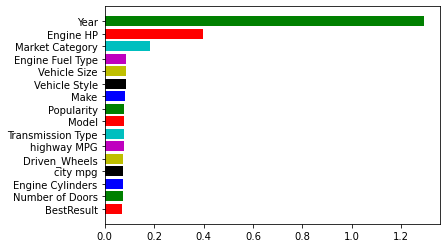

In [239]:
sort_perm = perm.sort_values(by=['AVG_Importance'])
plt.barh(sort_perm.index, sort_perm['AVG_Importance'],color = list('rgbkymc'))

### **Learning curve**
* The learning curve allows us to check potential pitfalls in the learning process
* The plot of the error versus complexity (depth of RF in our case) allows to identify overfitting 

KeyboardInterrupt: 

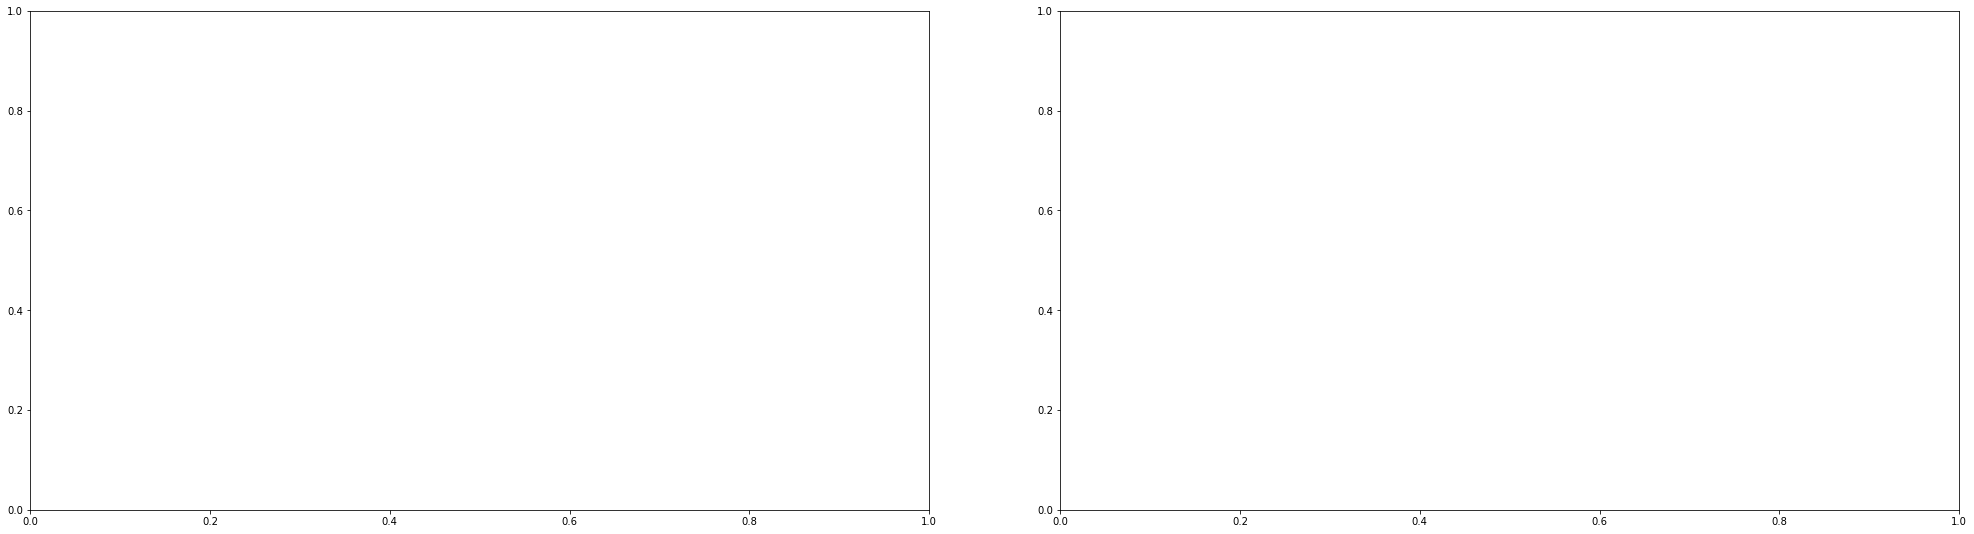

In [224]:

fig, axes1 = plt.subplots(1,2)
fig.set_size_inches(30,10)
fig.tight_layout(pad=10, w_pad=10, h_pad=10.0)



n_range = pd.Series([5,10,15,20,25,30,40,50,60,70,80,90,100])
x_range =np.int32(n_range * np.int32(X_train.shape[0]/100))

error_val=np.zeros(len(n_range))
error_train=np.zeros(len(n_range))
for i_n,n in enumerate(x_range) :  
    X_train_n = X_train.iloc[:n, :]
    y_train_n = y_train.iloc[:n, :]
    [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data( make='',X_train=X_train_n,X_val=X_val,X_test=X_test,y_train=y_train_n,y_val=y_val,y_test=y_test)
    rg.fit(X_train_tmp, y_train_tmp)
    y_val_pred=rg.predict(X_val_tmp)
    y_train_pred=rg.predict(X_train_tmp)
    y_test_pred=rg.predict(X_test_tmp)
    error_val[i_n] = metrics.mean_squared_error(np.exp(y_val_tmp), np.exp(y_val_pred), squared = False)
    error_train[i_n] =metrics.mean_squared_error(np.exp(y_train_tmp), np.exp(y_train_pred), squared = False)

axes = axes1[0]       
axes.plot(n_range, error_val, label = 'Validation ')
axes.plot(n_range, error_train, label = 'Train ')
axes.set_ylim(top=70000)

axes.set_title('Learning curve ',fontsize = 28)
axes.set_ylabel('RMSE',fontsize = 24)
axes.set_xlabel('Data percentage (%)',fontsize = 24)
axes.tick_params(axis='both', which='major', labelsize=24)

axes.legend()


rg_list = []
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=5, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=10, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=20, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=50, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=100, n_jobs=-1))



error_val=np.zeros(len(rg_list))
error_train=np.zeros(len(rg_list))
for j ,rg in enumerate (rg_list):
    n_range = np.linspace(10,100,10)#[d**2 for d in range(1,11, 0.5)]
    x_range =np.int32(n_range * X_train.shape[0]/100)
    
    [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data( make='',X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train,y_val=y_val,y_test=y_test)
    rg.fit(X_train_tmp, y_train_tmp)
    y_val_pred=rg.predict(X_val_tmp)
    y_train_pred=rg.predict(X_train_tmp)
    y_test_pred=rg.predict(X_test_tmp)
    error_val[j] = metrics.mean_squared_error(np.exp(y_val_tmp), np.exp(y_val_pred), squared = False)
    error_train[j] =metrics.mean_squared_error(np.exp(y_train_tmp), np.exp(y_train_pred), squared = False)


axes = axes1[1]           
axes.plot([5,10,20,50,100], error_val, label = 'Validation ')
axes.plot([5,10,20,50,100], error_train, label = 'Train ')
axes.set_ylim(top=40000)
axes.set_title('RMSE versus Depth of the RF ',fontsize = 28)
axes.set_ylabel('RMSE',fontsize = 24)
axes.set_xlabel('Depth',fontsize = 24)

axes.tick_params(axis='both', which='major', labelsize=24)

axes.legend()

In [297]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []

    predictors = pd.DataFrame( index=ind)


    for i, pred in enumerate(model.estimators_):
        predictors[i]=pred.predict(X)
    for x in range(len(X)):
        err_down.append(np.percentile(predictors.iloc[x,:], (100 - percentile) / 2. ))
        err_up.append(np.percentile(predictors.iloc[x,:], 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [344]:
perc= 90
rg= RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=20, n_jobs=-1)

[ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data( make='',X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train,y_val=y_val,y_test=y_test)
rg.fit(X_train_tmp, y_train_tmp)
y_val_pred=rg.predict(X_val_tmp)
y_train_pred=rg.predict(X_train_tmp)
y_test_pred=rg.predict(X_test_tmp)


err_down_train, err_up_train = pred_ints(rg, X_train_tmp, percentile=perc)
err_down_val, err_up_val = pred_ints(rg, X_val_tmp, percentile=perc)
err_down_test, err_up_test = pred_ints(rg, X_test_tmp, percentile=perc)


ci_train = np.array([np.array(err_down_train), np.array(err_up_train)])
ci_val = np.array([np.array(err_down_val), np.array(err_up_val)])
ci_test = np.array([np.array(err_down_test),np.array(err_up_test)])
plot_result_2(y_train_tmp, y_train_pred,ci_train,title = 'Training dataset',ylog = ylog)
plot_result_2(y_val_tmp, y_val_pred,ci_val,title = 'Validation dataset',ylog = ylog)
plot_result_2(y_test_tmp, y_test_pred,ci_test,title = 'Test dataset',ylog = ylog)